In [174]:
%matplotlib inline
import numpy as np
import pandas as pd
import fast_plotter as fast
import matplotlib.pyplot as plt

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 150

In [82]:
# This cell should become fast-manipulator
import re
import os
import numpy as np
import pandas as pd

# Interpret the filename
def get_read_options(filename):
    decipher = re.compile(r"tbl_(?P<index>.*?)(|--(?P<weights>.*))\.csv")
    groups = decipher.match(os.path.basename(filename))
    
    index_cols = groups.group("index").split(".")
    options = dict(index_col = range(len(index_cols)),
                   comment = "#"
                   )
    return options
    
def read_binned_df(filename):
    return pd.read_csv(filename, **get_read_options(filename))

def split_df(df, first_values, level=0):
    second = df.drop(first_values, level=level)
    second_values = second.index.unique(level=level)
    first = df.drop(second_values, level=level)
    return first, second

def split_data_sims(df, data_labels=["data"], dataset_level="dataset"):
    return split_df(df, first_values=data_labels, level=dataset_level)

def calculate_error(df, sumw2_label="variance", err_label="err", inplace=True):
    if not inplace:
        df = df.copy()
    for column in df:
        if sumw2_label in column:
            err_name = column.replace(sumw2_label, err_label)
            df[err_name] = np.sqrt(df[column])
    if not inplace:
        return df

def stack_sims(df, data_labels=["data"], dataset_level="dataset"):
    data, sims = split_data_sims(df, data_labels=data_labels, dataset_level=dataset_level)
    dataset_level_no = sims.index.names.index(dataset_level)
    group_levels = range(sims.index.nlevels)
    group_levels.remove(dataset_level_no)
    sim_stacked = sims.groupby(level=group_levels).cumsum()
    return data.append(sim_stacked)

In [62]:
!column -s, -t "carpenter/output/tbl_dataset.nMuons--weighted.csv" |head

dataset     nMuons  count     contents     variance
data        0       227265.0  227265.0     227265.0
data        1       223411.0  223411.0     223411.0
data        2       18707.0   18707.0      18707.0
data        3       1.0       1.0          1.0
dy          0       2181.0    787.2786     553.8454
dy          1       31499.0   14073.84     9972.951
dy          2       44048.0   19253.873    10659.372
dy          3       1.0       0.518289     0.26862353
qcd         0       124.0     18058.283    25392802.0


In [68]:
filename = "carpenter/output/tbl_dataset.nMuons--weighted.csv"
df = read_binned_df(filename)
df.head(10)

count       contents      variance
dataset nMuons                                       
data    0       227265.0  227265.000000  2.272650e+05
        1       223411.0  223411.000000  2.234110e+05
        2        18707.0   18707.000000  1.870700e+04
        3            1.0       1.000000  1.000000e+00
dy      0         2181.0     787.278600  5.538454e+02
        1        31499.0   14073.840000  9.972951e+03
        2        44048.0   19253.873000  1.065937e+04
        3            1.0       0.518289  2.686235e-01
qcd     0          124.0   18058.283000  2.539280e+07
        1           18.0   61102.220000  3.050105e+09

In [69]:
order = ["data", "ttbar", "wjets", "dy", "ww", "wz", "zz", "qcd", "single_top"]
df = df.reindex(order, axis=0, level="dataset")
df.head(10)

count       contents       variance
dataset nMuons                                        
data    0       227265.0  227265.000000  227265.000000
        1       223411.0  223411.000000  223411.000000
        2        18707.0   18707.000000   18707.000000
        3            1.0       1.000000       1.000000
ttbar   0        30856.0    6590.466000    1715.456500
        1         5792.0    1273.098100     334.434800
        2          293.0      65.912060      17.500875
wjets   0         7080.0   11070.950000   23975.477000
        1       102655.0  198530.100000  450967.100000
        2            2.0       2.502203       4.894644

In [72]:
df2 = calculate_error(df, inplace=False)
df2.head(8)

count      contents       variance         err
dataset nMuons                                                   
data    0       227265.0  227265.00000  227265.000000  476.723190
        1       223411.0  223411.00000  223411.000000  472.663728
        2        18707.0   18707.00000   18707.000000  136.773535
        3            1.0       1.00000       1.000000    1.000000
ttbar   0        30856.0    6590.46600    1715.456500   41.418070
        1         5792.0    1273.09810     334.434800   18.287559
        2          293.0      65.91206      17.500875    4.183405
wjets   0         7080.0   11070.95000   23975.477000  154.840166

In [73]:
data, sims = split_data_sims(df2)
data

count  contents  variance         err
dataset nMuons                                          
data    0       227265.0  227265.0  227265.0  476.723190
        1       223411.0  223411.0  223411.0  472.663728
        2        18707.0   18707.0   18707.0  136.773535
        3            1.0       1.0       1.0    1.000000

In [67]:
sims.head()

count      contents      variance          err
dataset nMuons                                                  
dy      0        2181.0    787.278600  5.538454e+02    23.533920
        1       31499.0  14073.840000  9.972951e+03    99.864663
        2       44048.0  19253.873000  1.065937e+04   103.244235
        3           1.0      0.518289  2.686235e-01     0.518289
qcd     0         124.0  18058.283000  2.539280e+07  5039.127107

In [91]:
stacked_df = stack_sims(df2)#.reset_index()
stacked_df.head(10)

count       contents       variance         err
dataset nMuons                                                    
data    0       227265.0  227265.000000  227265.000000  476.723190
        1       223411.0  223411.000000  223411.000000  472.663728
        2        18707.0   18707.000000   18707.000000  136.773535
        3            1.0       1.000000       1.000000    1.000000
ttbar   0        30856.0    6590.466000    1715.456500   41.418070
        1         5792.0    1273.098100     334.434800   18.287559
        2          293.0      65.912060      17.500875    4.183405
wjets   0        37936.0   17661.416000   25690.933500  196.258236
        1       108447.0  199803.198100  451301.534800  689.828399
        2          295.0      68.414263      22.395519    6.395789

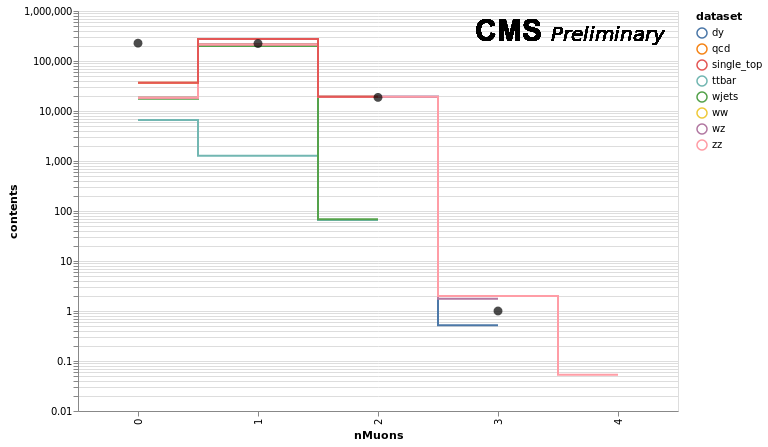

In [158]:
spec = {
   '$schema': 'https://vega.github.io/schema/vega-lite/v2.json',
   'config': {},
   'width': 600,
   'height': 400,
   'layer': [{
       "selection": {"grid": {"type": "interval", "bind": "scales"}},
       "mark": {"type": "line", "interpolate": "step","tooltip": {"field": ""}},
       "encoding": {
           "y": {
               "field": "contents",
               "type": "quantitative", 
               "scale": {"type": "log", "domain": [0.01]}
           },
           "tooltip": [{"field": "contents"}, {"field": "err"}],
           "color": {"field": "dataset", "type": "nominal"}
       },
       "transform": [{"filter": "datum.dataset != 'data'"}]
   },{
       "mark": {"type": "point", "filled": "true", "size": 80, "color": "black"},
       "encoding": {
           "y": {"field": "contents","type": "quantitative"},
           "tooltip": [{"field": "contents"}, {"field": "err"}]
       },
       "transform": [{"filter": "datum.dataset == 'data'"}]
   },{
       "mark": {"type": "text", "text": "CMS", "size": 30, "font": "Arial", "fontWeight": "bold"},
       "encoding": {"x": {"value": 430}, "y": {"value": 30}}
   },{
       "mark": {"type": "text", "text": "Preliminary", "size": 20, "fontStyle": "italic", "fontWeight": 5},
       "encoding": {"x": {"value": 530}, "y": {"value": 30}}
   }
   ],
    'encoding': {
        "x": {"field": "nMuons", "type": "ordinal", "grid": "true"}
    }
}
from vega import VegaLite
plot = VegaLite(spec, stacked_df.reset_index())
plot

Text(0.64,0.932,'Preliminary')

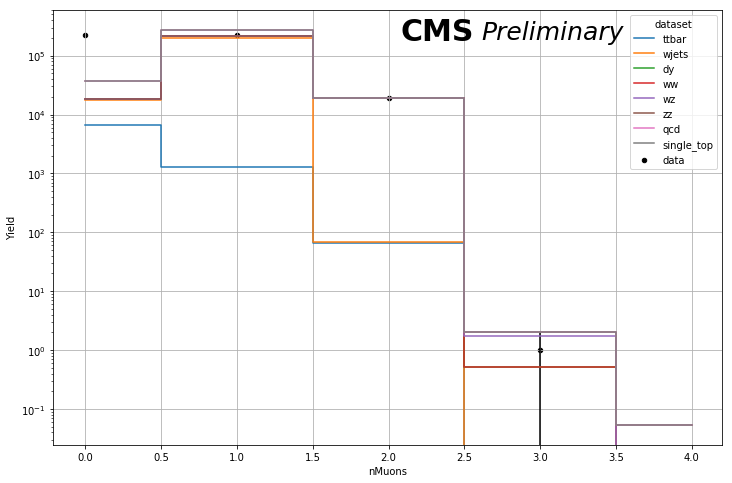

In [227]:
ax = plt.subplot(111)

sims["contents"].unstack(0).plot.line(drawstyle="steps-mid", logy=True, stacked=True, figsize=(12, 8), ax=ax)
data.reset_index().plot.scatter(x="nMuons", y="contents", yerr="err", color="k", label="data", ax=ax)

plt.grid(True)
plt.ylabel("Yield")
plt.annotate("CMS", (0.52, 0.93), xycoords="axes fraction",fontsize=30, fontweight="bold")
plt.annotate("Preliminary", (0.64, 0.932), xycoords="axes fraction",fontsize=25, fontstyle="italic")